In [2]:
from sympy import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import math
from astropy import constants as const

In [21]:
from sympy import *
import numpy as np
from scipy.integrate import solve_ivp
import math
from astropy import constants as const
from astropy import units as u


class STMint:
    """ State Transition Matrix Integrator
    A tool for numerical integration of variational
    equations associated with a symbolically specified dynamical system.

    * Attributes only exist if the user chooses to create variational equations
    with given dynmaics
    """

    # ATTRIBUTES
    # Attribute vars: the variables used in the symbolic integration
    # Invariant: vars is a 1-dimensional Sympy Matrix
    #
    # Attribute dynamics: the dynamics to be symbolically integrated
    # Invariant: dynamics is the dynamic equation(s) in the form
    # of sympy expressions
    #
    # Attribute lambda_dynamics: the lambdified dynamic equations
    # Invariant: lambda_dynamics is a lambdified sympy expression
    #
    # *Attribute jacobian: the jacobian of the dynamics
    # Invariant: jacobian is an n-dimensional sympy Matrix or None
    #
    # *Attribute STM: the symbolic state transition matrix
    # Invariant: STM is an nxn sympy Matrix, the dimensions of STM is equal to
    # number of variables used or None
    #
    # *Attribute variational: the variatonal equations of the dynamical system
    # Invariant: variational is an n-dimensional sympy Matrix or None
    #
    # *Attribute lambda_dynamics_and_variational: the lambdified dynamic and
    # variational equations
    # Invariant: lambda_dynamics_and_variational is a lambdified sympy expression
    # or None

    def __init__(self,
                 vars=None,
                 dynamics=None,
                 preset="",
                 preset_mult=1,
                 variation=True):
        """
        Args:
            vars (1-dimensional sympy matrix)
                The variables used in the symbolic integration.

            dynamics (sympy expression(s))
                The dynamics to be symbolically integrated

            preset (string)
                Dynamic and Variational equation preset. Current presets are:
                    twoBody
                        Two body motion
                    twoBodyEarth
                        Two body motion around Earth
                    twoBodySun
                        Two body motion around the Sun
                    threeBody
                        Three body motion
                    threeBodySunEarth
                        Three body motion around the Sun and Earth
                    threeBodyEarthMoon
                        Three body motion around the Earth and Moon

            preset_mult (float)
                Constant multiple of potential V for 2-body motion

            variational (boolean)
                Whether variational equations will be created

            const_mult (float)
                Constant multiple of potential V for 2-body motion

            variational (boolean)
                Whether variational equations will be created
        """
        # preset for two body motion
        if "twoBody" in preset:
            self.presetTwoBody(preset, preset_mult)
        elif "threeBody" in preset:
            self.presetThreeBody(preset, preset_mult)
        else:
            # create sympy symbols
            for elem in vars:
                elem = symbols(str(elem))

            self.vars = Matrix(vars)
            self.dynamics = dynamics

        # lambdify dynamics
        self.lambda_dynamics = lambdify(self.vars, self.dynamics, "numpy")

        # if user wants to use variational equations
        self.setVarEqs(variation)

    def presetTwoBody(self, preset, preset_mult):
        """ This method instanciates STMint under the preset of two body dynamics

        This method calculates two body motion dynamics with the option for
        preset constant multiples.

        Args:
            preset (string)
                Dynamic and Variational equation preset. Current presets are:
                    twoBody
                        Two body motion
                    twoBodyEarth
                        Two body motion around Earth
                    twoBodySun
                        Two body motion around the Sun

            preset_mult (float)
                Constant multiple of potential V for 2-body motion
        """

        x, y, z, vx, vy, vz = symbols("x,y,z,vx,vy,vz")

        if "Earth" in preset:
            V = const.GM_earth / sqrt(x**2 + y**2 + z**2) << u.km**3 / u.s**2
        if "Sun" in preset:
            V = const.GM_sun / sqrt(x**2 + y**2 + z**2) << u.km**3 / u.s**2
        else:
            V = preset_mult / sqrt(x**2 + y**2 + z**2)

        r = Matrix([x, y, z])
        vr = Matrix([vx, vy, vz])
        dVdr = diff(V, r)
        RHS = Matrix.vstack(vr, dVdr)

        self.vars = Matrix([x, y, z, vx, vy, vz])
        self.dynamics = RHS

    def presetThreeBody(self, preset, preset_mult):
        """ This method instnaciates STMint under the preset of three body
        restricted circular motion.

        This method calculates three body restricted circular motion dynamics
        with the option for a preset mass parameter.

        Args:
            preset (string)
                Dynamic and Variational equation preset. Current presets for
                three body motion are:
                    threeBody
                        Three body motion
                        (Default to SunEarth)
                    threeBodySunEarth
                        Three body motion around the Sun and Earth
                    threeBodyEarthMoon
                        Three body motion around the Earth and Moon

            preset_mult (float)
                Mass parameter for two body motion (mu)
        """

        x, y, z, vx, vy, vz = symbols("x,y,z,vx,vy,vz")

        if "SunEarth" in preset:
            mu = 3.036e-6
        if "EarthMoon" in preset:
            mu = 1.215e-2
        if preset_mult != 1:
            mu = preset_mult
        else:
            mu = 3.036e-6

        mu1 = 1 - mu
        mu2 = mu

        r1 = sqrt((x + mu2)**2 + (y**2) + (z**2))
        r2 = sqrt((x - mu1)**2 + (y**2) + (z**2))

        U = (-1 / 2) * (mu1 * (r1**2) + mu2 *
                        (r2**2)) - (mu1 / r1) - (mu2 / r2)

        dUdx = diff(U, x)
        dUdy = diff(U, y)
        dUdz = diff(U, z)

        RHS = Matrix([
            vx, vy, vz, ((-1 * dUdx) + 2 * vy), ((-1 * dUdy) - 2 * vx),
            (-1 * dUdz)
        ])

        self.vars = Matrix([x, y, z, vx, vy, vz])
        self.dynamics = RHS

    def setVarEqs(self, variation):
        """ This method creates or deletes assicioated varitional equations with
        given dynmaics

        This method first takes the jacobian of the dynamics, and creates a
        symbolic state transition matrix (STM). The jacobian and STM are then
        multiplied together to create the variational equations. These
        equations are then lambdified. If variation is False, all of these values
        are set to none.

        Args:
            variation (boolean)
                Determines whether to create or delete variational equations.
        """
        if (variation):
            self.jacobian = self.dynamics.jacobian(self.vars.transpose())
            self.STM = MatrixSymbol("phi", len(self.vars), len(self.vars))
            self.variational = self.jacobian * self.STM
            self.lambda_dynamics_and_variational = lambdify(
                (self.vars, self.STM),
                Matrix.vstack(self.dynamics.transpose(),
                              Matrix(self.variational)), "numpy")
        else:
            self.jacobian = None
            self.STM = None
            self.variational = None
            self.lambda_dynamics_and_variational = None

# =============================================================================
# IVP Solver Functions
# =============================================================================

    def _dynamics_solver(self, t, y):
        """ Function to mimic right hand side of a dynamic system for integration

        Method unpacks initial coniditions y from solve_ivp and sends it to the
        predefined lamdified dynamics.

        Args:
            t (float)
                Independent variable of initial conditions

            y (float n array)
                Array of initial conditions of solve_ivp

        Returns:
            lambda_dynamics (float n array)
                Array of values of dynamics subjected to initial conditions
        """

        lambda_dynamics = self.lambda_dynamics(*y).flatten()

        return lambda_dynamics

    def _dynamics_and_variational_solver(self, t, y):
        """ Function to mimic right hand side of a dynamic system with variational
            equations integrattion

        Method unpacks initial coniditions y from solve_ivp and sends it to the
        predefined lamdified dynamics and variational equations.

        Args:
            t (float)
                Independent variable of initial conditions

            y (float n array)
                Array of initial conditions of solve_ivp

        Returns:
            lambda_dynamics_and_variational (float n array)
                Array of values of dynamics and variational equations subjected
                to initial conditions
        """

        l = len(self.vars)
        lambda_dynamics_and_variational = self.lambda_dynamics_and_variational(
            y[:l], np.reshape(y[l:], (l, l))).flatten()

        return lambda_dynamics_and_variational


# =============================================================================
# Clones of solve_ivp
# =============================================================================

    def dyn_int(self,
                t_span,
                y0,
                method='RK45',
                t_eval=None,
                dense_output=False,
                events=None,
                vectorized=False,
                args=None,
                **options):
        """ Clone of solve_ivp

        Method uses _dynamics_solver to solve an innitial value prolbem with given
        dynamics. This method has the same arguments and Scipy's solve_ivp function.

        Non-optional arguments are listed below.
        See documentation of solve_ivp for a full list and description of arguments
        and returns
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

        Args:
            t_span (2-tuple of floats)
                Interval of integration (t0, tf). The solver starts with t=t0
                and integrates until it reaches t=tf.

            y0 (array_like, shape (n,))
                Initial state. For problems in the complex domain, pass y0 with
                a complex data type (even if the initial value is purely real).

        Returns:
            Bunch object with multiple defined fields, such as:
                t (ndarray, shape (n_points,))
                    Time points.

                y (ndarray, shape (n, n_points))
                    Values of the solution at t.

                sol (OdeSolution or None)
                    Found solution as OdeSolution instance;
                    None if dense_output was set to False.
        """

        return solve_ivp(self._dynamics_solver, t_span, y0, method, t_eval,
                         dense_output, events, vectorized, args, **options)

    def dynVar_int(self,
                   t_span,
                   y0,
                   output='raw',
                   method='RK45',
                   t_eval=None,
                   dense_output=False,
                   events=None,
                   vectorized=False,
                   args=None,
                   **options):
        """ Clone of solve_ivp

        Method uses _dynamics_and_variational_solver to solve an innitial value
        prolbem with given dynamics and variational equations. This method has
        the same arguments and Scipy's solve_ivp function.

        Non-optional arguments are listed below.
        See documentation of solve_ivp for a full list and description of arguments
        and returns
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

        Args:
            t_span (2-tuple of floats)
                Interval of integration (t0, tf). The solver starts with t=t0
                and integrates until it reaches t=tf.

            y0 (array_like, shape (n,))
                Initial state. For problems in the complex domain, pass y0 with
                a complex data type (even if the initial value is purely real).

            output (str)
                Output of dynVar_int, options include:
                    raw
                        Raw bunch object from solve_ivp
                    final
                        The state vector and STM at the final time only
                    all
                        The state vector and STM at all times

        Returns:
            If output is 'raw'
                Bunch object with multiple defined fields, such as:
                    t (ndarray, shape (n_points,))
                        Time points.

                    y (ndarray, shape (n, n_points))
                        Values of the solution at t.

                    sol (OdeSolution or None)
                        Found solution as OdeSolution instance;
                        None if dense_output was set to False.

            If output is 'final'
                vecAndSTM (tuple)
                    A tuple with the state vector and STM

            If output is 'all'
                allVecAndSTM (2d list)
                    A list with the state vector and STM as a 7x6 matrix for each
                    respective time value

        """
        assert self.variational != None, "Variational equations have not been created"
        initCon = np.vstack((np.array(y0), np.eye(len(self.vars))))

        solution = solve_ivp(self._dynamics_and_variational_solver, t_span,
                             initCon.flatten(), method, t_eval, dense_output,
                             events, vectorized, args, **options)

        if 'raw' in output:
            return solution
        if 'final' in output:
            t_f = []

            for i in range(len(solution.y)):
                t_f.append(solution.y[i][-1])

            vecAndSTM = (np.array([t_f[:6]]), np.reshape(t_f[6:], (6, 6)))

            return vecAndSTM
        if 'all' in output:
            allVecAndSTM = [solution.y, solution.t]

            return allVecAndSTM


In [75]:
x,y,z,vx,vy,vz=symbols("x,y,z,vx,vy,vz")

mu = const.GM_earth.value * 10**(-9)
V = mu / sqrt(x**2 + y**2 + z**2)

r = Matrix([x,y,z])
vr = Matrix([vx,vy,vz])

dVdr = diff(V,r)

dynamics = Matrix.vstack(vr,dVdr)

int1 = STMint([x,y,z,vx,vy,vz], dynamics)

sol = int1.dynVar_int([0,(2*math.pi)], [1,0,0,1,0,0], max_step=.1)

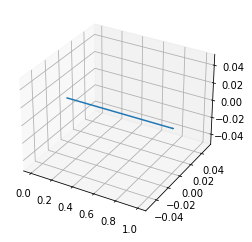

In [76]:
# ys.
ys = sol.y[:9].T

# plot 3d trajectory
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(ys[:,0], ys[:,1], ys[:,2])
plt.show()